In [1]:
#repeat of model training using the substrate descriptors without coa part
import h5py
import numpy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from pandas import read_csv
import pandas as pd
from matplotlib.pyplot import subplots, axes, scatter, xticks
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from numpy import mean, array
import time

In [77]:
#functions
#making embbeding df
def T5_match(reduced_embedding, long_df):
    start_time = time.perf_counter()
    reduced_file = h5py.File(reduced_embedding, "r")
    seq_embeddings = numpy.empty(1024)
    for item in long_df["Gene"]:
        #res = [key for key, val in indexes.items() if item  in val]
        array = numpy.asarray(reduced_file[item])
        #removinf nans
        array = numpy.nan_to_num(array, nan=0.0)
        seq_embeddings = numpy.vstack((seq_embeddings,array))
    seq_embeddings = seq_embeddings[1:]
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print("Elapsed time: ", elapsed_time)
    return seq_embeddings    
#matching embedding with Gene name in pooled embeddings
def substrate_match(long_df, descriptors, smiles):
    subs_descpitors = numpy.empty(descriptors.shape[1])
    for item in long_df['Substrate']:
        #print(item)
        index = smiles.index[smiles["Substrate"]==item][0]
        subs_descpitors = numpy.vstack((subs_descpitors, descriptors[index]))
    subs_descpitors = subs_descpitors[1:]
    return subs_descpitors
#function for substrate embedding generation
def substrate_descriptor(smiles, dimension):
    substrate_desc = {}
    for item in dimension:
        substrate_desc[item] = numpy.empty(dimension[item])
    for item in smiles['SMILES']:
        #print(item.index())
        mol = Chem.MolFromSmiles(item)
        models = {'Morgan': AllChem.GetMorganFingerprintAsBitVect(mol,2, 2048),
         'RDKit': AllChem.GetRDKitFPGenerator().GetFingerprint(mol),
         'MACCS': Chem.MACCSkeys.GenMACCSKeys(mol)}
        for model in models:
            fp = models[model]
            array = numpy.zeros((0, ), dtype=numpy.int8)
            DataStructs.ConvertToNumpyArray(fp, array)
            substrate_desc[model] = numpy.vstack((substrate_desc[model], array))
    for item in substrate_desc:
        substrate_desc[item]= substrate_desc[item][1:]
    return substrate_desc
#calculate scores for plotting
def model_score(score):
    mean_scores = dict()
    for item in score:
        print(item)
        metr = list()
        sd = list()
        for value in score[item]:
            metr.append(mean(value, axis =0 ))
            sd.append(numpy.std(value, axis = 0))
        mean_scores[item] = [metr, sd]
    return mean_scores

#make ML df for training
def makeMLset(input_df, fingerprints, adress):
    embeddings = dict()
    embeddings["ProtTrans"] = T5_match(adress, input_df)

    substrate_fp = dict()
    for key in fingerprints:
        substrate_fp[key] = substrate_match(input_df, fingerprints[key], smiles)
    X = dict()
    for item in substrate_fp:
        for item2 in embeddings:
            name = str(item) + '/' + str(item2)
            X[name] = numpy.hstack((embeddings[item2],  substrate_fp[item]))
    return(X)

#function for the model training 
def model_test(train_X, y_train, test_X, test_y):
    import random
    pred_score_all, pred_value_all = dict(), dict()
    for item in test_X:
        X_train = train_X[item]
        pred_score, pred_roc_auc, pred_precision, pred_recall, pred_f1 = list(), list(),list(),list(), list()
        pred_value = list()
        for i in range(0,100):
            RANDOM_STATE = random.randint(0, 10000000)
            classifiers = {
            'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
            'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
            'Multi-layer Perceptron': MLPClassifier(max_iter=50000, random_state=RANDOM_STATE)}
            pred_score_clf, pred_roc_auc_clf, pred_precision_clf, pred_recall_clf, pred_f1_clf = list(),list(), list(),list(),list()
            pred_clf = list()
            for name, clf in classifiers.items():
                clf.fit(X_train, y_train)
                y_pred_prob = clf.predict_proba(test_X[item])[:, 1]
                y_pred = clf.predict(test_X[item])
                pred_score_clf.append(clf.score(test_X[item], test_y))
                pred_roc_auc_clf.append(roc_auc_score(test_y, y_pred_prob))
                pred_precision_clf.append(precision_score(test_y, y_pred))
                pred_recall_clf.append(recall_score(test_y, y_pred))
                pred_f1_clf.append(f1_score(test_y, y_pred))
                pred_clf.append(y_pred)
            pred_score.append(pred_score_clf), 
            pred_roc_auc.append(pred_roc_auc_clf)
            pred_recall.append(pred_recall_clf)
            pred_precision.append(pred_precision_clf)
            pred_f1.append(pred_f1_clf)
            pred_value.append(pred_clf)
        pred_score_all[item] = (pred_score,pred_roc_auc, pred_precision, pred_recall, pred_f1) 
        pred_value_all[item] = pred_value
    results = (pred_score_all,pred_value_all )
    return results    

#function to plot all 5 metrics from model_score function
def plot_model_score(classifiers, score_model):
    metrics_list = ["Accuracy", "ROC AUC", "Precision", "Recall", "F1"]
    labels = classifiers.keys()
    x = numpy.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = subplots(ncols = len(metrics_list), figsize = (20,8))
    for i in range(0,len(metrics_list)):
        multiplier = 0
        for attribute, measurement in score_model.items():
            offset = width * multiplier
            rects = ax[i].bar(x + offset, measurement[0][i], width, yerr = measurement[1][i], label = attribute)
            multiplier += 1
        ax[i].set_ylabel(metrics_list[i])
        ax[i].set_xticks(x + width)
        ax[i].set_xticklabels(labels, rotation=-90)
        if i == len(metrics_list)-1:        
            ax[i].legend()
        ax[i].set_ylim(0.5, 1)

#function to export all 5 metrics for each model and run
def score_all_points(score_all):
    metrics_list = ["Accuracy", "ROC AUC", "Precision", "Recall", "F1"]
    embed, model, metrics, value = list(), list(),list(),list()
    for item in score_all:
        for metric in score_all[item]:
            for run in metric:
                for i in range(0,3):
                    embed.append(item)
                    metrics.append(metrics_list[score_all[item].index(metric)])
                    model.append(list(classifiers.keys())[i])
                    value.append(run[i])


    score_df = pd.DataFrame({"Embedding" : embed,
                           "Model": model,
                           "Metric": metrics,
                           "value":value})  
    return score_df

#function to average prediction for each model. The structure [embedding]-[run]-[model]-[prediction]
def average_prediction(score_all, classifiers, input_df, outfile):
    prediction = dict()
    for item in score_all:
        averaged = mean(score_all[item], axis = 0)
        for i in range(0,3):
            name = item + "_" + list(classifiers.keys())[i]
            prediction[name] = averaged[i]


    average_df = pd.DataFrame(prediction)
    temp_df = pd.concat([input_df, average_df], axis = 1)
    temp_df.to_csv(outfile, sep=";")
    return temp_df

#training model for prediction export using MACCS/Prottrans and MLP 
def make_prediction(input_X, train_x, train_y, input_df, outfile):
    import random
    score = list()
    y_pred = list()
    for i in range(0,100):
        score_clf = list()
        RANDOM_STATE = random.randint(0, 10000000)
        clf = MLPClassifier(max_iter=50000, random_state=RANDOM_STATE)
        clf.fit(train_x, train_y)
        y_pred.append(clf.predict(input_X))
    temp_df = input_df[["Gene", "Substrate"]] 
    temp_df["pred"] = list(mean(y_pred, axis = 0))
    temp_df.to_csv(outfile, sep=";")

In [3]:
#reading smiles and making ecpf
dimension = {'Morgan': 2048,
         'RDKit': 2048,
         'MACCS': 167}
smiles = read_csv("../input_data/smiles_combined.csv")
fingerprints = substrate_descriptor(smiles,  dimension)


In [4]:
#reading training df and making input
long_df = read_csv("../input_data/T3PKS_cellfree_df.csv")
X_cellfree = makeMLset(long_df, fingerprints, '../input_data/T3PKS_embeddings.h5')

Elapsed time:  0.09501549999998815


In [85]:
y_train = long_df['value']

score_all = dict()
for item in X_cellfree:
    sss = StratifiedShuffleSplit(random_state=12345, n_splits=100, test_size=0.3)
    score, roc_auc, precision, recall, f1 = list(), list(),list(),list(), list()
    
    for train_index, test_index in sss.split(X_cellfree[item], y_train):
        X_s, y_s = X_cellfree[item][train_index, :], y_train[train_index]
        new_obs_s, y_test_s = X_cellfree[item][test_index, :], y_train[test_index]
        score_clf, roc_auc_clf, precision_clf, recall_clf, f1_clf = list(), list(),list(),list(), list()
        RANDOM_STATE = random.randint(0, 10000000)
        classifiers = {'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
                       'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
                       'Multi-layer Perceptron': MLPClassifier(max_iter=50000, random_state=RANDOM_STATE)}
        for name, clf in classifiers.items():
            clf.fit(X_s, y_s)
            y_pred_prob = clf.predict_proba(new_obs_s)[:, 1]
            y_pred = clf.predict(new_obs_s)
            score_clf.append(clf.score(new_obs_s, y_test_s))
            roc_auc_clf.append(roc_auc_score(y_test_s, y_pred_prob))
            precision_clf.append(precision_score(y_test_s, y_pred))
            recall_clf.append(recall_score(y_test_s, y_pred))
            f1_clf.append(f1_score(y_test_s, y_pred))
        score.append(score_clf), 
        roc_auc.append(roc_auc_clf)
        recall.append(recall_clf)
        precision.append(precision_clf)
        f1.append(f1_clf)
    score_all[item] = (score,roc_auc, precision, recall, f1)


Morgan/ProtTrans
RDKit/ProtTrans
MACCS/ProtTrans


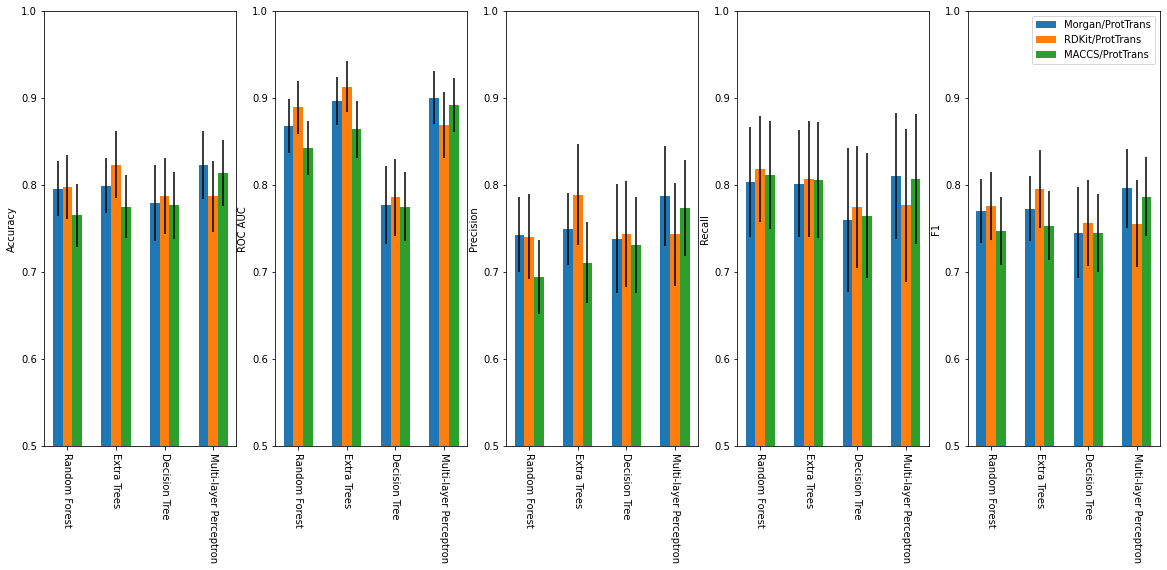

In [86]:
#plot results
mean_model_scores = model_score(score_all)
plot_model_score(classifiers, mean_model_scores)
#exporting results
training_all_score = score_all_points(score_all[0])
training_all_score.to_csv("../output_data/model_scores_training.csv")

In [79]:
#making prediction for all substrates
substrate_df = read_csv("../input_data/substrate_prediction_df.csv")
X_substrates_prediction = makeMLset(substrate_df, fingerprints, '../input_data/T3PKS_embeddings.h5')
make_prediction(X_substrates_prediction["MACCS/ProtTrans"], X_cellfree["MACCS/ProtTrans"], 
                long_df["value"], substrate_df, "../output_data/all_substrate_prediction.csv")

Elapsed time:  0.12944666699695517


In [7]:
#making datasets for xtra substrates
xtra_df = read_csv("../input_data/xtra_substrates.csv")
X_substrates = makeMLset(xtra_df, fingerprints, '../input_data/T3PKS_embeddings.h5')
#test on xtrasubstrates
extra_score = model_test(X_cellfree, long_df['value'], X_substrates, xtra_df['value'])
extra_score_model = model_score(extra_score[0])
classifiers = {'Random Forest': RandomForestClassifier(),'Decision Tree': DecisionTreeClassifier(),'Multi-layer Perceptron': MLPClassifier(max_iter=50000)}
plot_model_score(classifiers, extra_score_model)
#export results
extra_substrate_all_score = score_all_points(extra_score[0])
extra_substrate_all_score.to_csv("../output_data/extra_substrates_scores.csv")
extra_substrate_prediction = average_prediction(extra_score[1], classifiers, xtra_df, "../output_data/extra_substrates_prediction.csv")

Elapsed time:  0.04169483299997978


In [73]:
#making datasets for published enzymes
published_df = read_csv("../input_data/published.csv")
published_df = published_df.loc[published_df["Organism"] == "Fungi"]
published_df = published_df.reset_index()
X_published = makeMLset(published_df, fingerprints, '../input_data/T3PKS_embeddings.h5')
published_score = model_test(X_cellfree, long_df['value'], X_published, published_df['value'])
#plot results 
published_model = model_score(published_score[0])
plot_model_score(classifiers, published_model)
#export results
published_all_score = score_all_points(published_score[0])
published_all_score.to_csv("../output_data/published_scores.csv")
published_prediction = average_prediction(published_score[1], classifiers, published_df, "../output_data/published_prediction.csv")

Elapsed time:  0.055202416000611265


In [75]:
#additional set for bacterial and plant T3PKS
plant_bacterial = read_csv("../input_data/published.csv")
plant_bacterial = plant_bacterial.loc[plant_bacterial["Organism"] != "Fungi"]
plant_bacterial = plant_bacterial.reset_index()
#predction
X_plant = makeMLset(plant_bacterial, fingerprints, '../input_data/T3PKS_embeddings.h5')
plant_score = model_test(X_cellfree, long_df['value'], X_plant, plant_bacterial['value'])
#plot results
plant_model = model_score(plant_score[0])
plot_model_score(classifiers, plant_model)
#export results 
plant_all_score = score_all_points(plant_score[0])
plant_all_score.to_csv("../output_data/published_plant_scores.csv")
plant_prediction = average_prediction(plant_score[1], classifiers, plant_bacterial, "../output_data/published_plant_prediction.csv")

Elapsed time:  0.03688120799961325
